In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/Jill


In [ ]:
# Change the working directory to the project folder in Google Drive
FOLDERNAME = 'Colab Notebooks/Jill'
%cd /content/drive/MyDrive/$FOLDERNAME/

In [ ]:
# !pip uninstall -y torch torchvision torchaudio
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import DistilBertTokenizer, DistilBertModel
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import re
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GroupShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import seaborn as sns

In [ ]:
# Set random seed and deterministic behavior for reproducibility
torch.manual_seed(10)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [ ]:
# Load the selected dataset
DATA = 'amazon.xlsx'
# DATA = 'Amazon_ToiletPaper.xlsx'
# DATA = 'ebay_appliance.xlsx'
data = pd.read_excel(DATA)
data.head()

,id,title,price,rating,reviews,sales,link,review1,review2,review3
0,1,West Bend 47413 Hi-Rise Programmable Bread Mak...,3520,4.2,2360.0,500,NaN,NaN,NaN,NaN
1,2,"2LB Bread Maker Machine, OSIPOTO 17 in 1 Autom...",3200,4.8,180.0,2000,NaN,NaN,NaN,NaN
2,3,"Cuisinart Bread Maker Machine, Compact and Aut...",4096,4.4,15346.0,4000,NaN,NaN,NaN,NaN
3,4,"Amazon Basics Programmable Bread Maker, 2 Poun...",2280,4.3,5700.0,1000,NaN,NaN,NaN,NaN
4,5,Customers frequently viewed,6006,4.4,61.0,100,NaN,NaN,NaN,NaN


In [ ]:
# Identify records with duplicate product titles
duplicate_titles = data[data.duplicated(subset='title', keep=False)]
print({duplicate_titles.shape[0]})
display(duplicate_titles)

# Count how many times each duplicated title appears
title_counts = duplicate_titles['title'].value_counts()
print(title_counts[title_counts > 1])

{0}


,id,title,price,rating,reviews,sales,link,review1,review2,review3


Series([], Name: count, dtype: int64)


In [ ]:
# Data Preprocessing

# Remove rows with missing sales values
data = data.dropna(subset=['sales'])

# Fill missing values in review text fields with 'N/A'
data.loc[:, 'review1'] = data['review1'].fillna('N/A')
data.loc[:, 'review2'] = data['review2'].fillna('N/A')
data.loc[:, 'review3'] = data['review3'].fillna('N/A')

# Fill missing ratings with the median rating value
median_rating = data['rating'].median()
data.loc[:, 'rating'] = data['rating'].fillna(median_rating)

# Clean and fill the 'reviews' column
# Remove commas, convert to float, and fill missing values with 0
data['reviews'] = data['reviews'].astype(str).str.replace(',', '').astype(float).fillna(0)

# Clean and convert the 'price' column to numeric format
data['price'] = data['price'].astype(str)  # Convert to string to handle mixed types
data['price'] = data['price'].str.replace(r'NT\$\s*', '', regex=True)  # Remove NT$ symbols
data['price'] = data['price'].str.replace(',', '', regex=True)  # Remove commas
data['price'] = pd.to_numeric(data['price'], errors='coerce')  # Convert to float, set invalid entries as NaN

# Reset and reassign the 'id' column
data.drop(columns='id', inplace=True, errors='ignore')
data = data.reset_index(drop=True)
data.insert(0, 'id', range(1, len(data) + 1))
data['id'] = data['id'].astype('int64')

<ipython-input-8-203ad12ee57d>:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['N/A' 'N/A' 'N/A' ... 'N/A' 'N/A' 'N/A']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data.loc[:, 'review1'] = data['review1'].fillna('N/A')
<ipython-input-8-203ad12ee57d>:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['N/A' 'N/A' 'N/A' ... 'N/A' 'N/A' 'N/A']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data.loc[:, 'review2'] = data['review2'].fillna('N/A')
<ipython-input-8-203ad12ee57d>:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['N/A' 'N/A' 'N/A' ... 'N/A' 'N/A' 'N/A']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data.loc[:, 'review3'] = data['r

In [ ]:
# Display the number of records in the dataset after data preprocessing
print(f'Data Quantity: {data.shape[0]}')

Data Quantity: 4338


In [ ]:
# Standardize numerical feature columns
scaler = StandardScaler()
numeric_cols = ['price', 'rating', 'reviews']
data[numeric_cols] = scaler.fit_transform(data[numeric_cols])

In [ ]:
# Encode target labels for classification

# Method 1: Use quartile-based binning (commented out since Method 2 performed better in evaluation)
# data['label'] = pd.qcut(data['sales'], q=4, labels=[0, 1, 2, 3])

# Method 2: Use log-transformed sales and equal-width binning
# This approach helps reduce the long-tail effect and yielded better classification accuracy in testing
data['log_sales'] = np.log1p(data['sales'])

# Divide the log-transformed sales range into 4 equal-width bins
step = (data['log_sales'].max() - data['log_sales'].min()) / 4
bins = [data['log_sales'].min() + step * i for i in range(5)]

# Print the corresponding original sales ranges for reference
original_ranges = [(np.expm1(bins[i]), np.expm1(bins[i+1])) for i in range(len(bins) - 1)]
print("Original Sales Ranges:")
for i, (lower, upper) in enumerate(original_ranges):
    print(f"SalesCategory {i}: {lower:.0f} - {upper:.0f}")

# Assign labels based on the log-scaled bins
data['label'] = pd.cut(data['log_sales'], bins=bins, labels=[0, 1, 2, 3], include_lowest=True)

# Convert labels to integer type after ensuring no NaN values
data['label'] = data['label'].astype(int)

# Display the number of samples in each label category (after binning)
print(data['label'].value_counts().sort_index())

Original Sales Ranges:
SalesCategory  0: 1 - 21
SalesCategory  1: 21 - 244
SalesCategory  2: 244 - 2710
SalesCategory  3: 2710 - 30000


In [ ]:
# Initialize the tokenizer for the DistilBERT model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Define a custom PyTorch Dataset to handle text and numerical features
class ProductDataset(Dataset):
    def __init__(self, data):
        # Concatenate product title and review text fields into a single input string
        self.texts = data['title'] + ' ' + data['review1'].fillna('') + ' ' + data['review2'].fillna('') + ' ' + data['review3'].fillna('')
        self.numeric_features = data[numeric_cols].values  # Extract numerical features
        self.labels = data['label'].values  # Extract target labels

    def __len__(self):
        return len(self.texts)  # Return the total number of samples

    def __getitem__(self, idx):
        # Tokenize the text input using DistilBERT tokenizer
        encoded = tokenizer(
            self.texts[idx],
            padding='max_length',
            truncation=True,
            max_length=128,
            return_tensors='pt'
        )

        # Return a dictionary containing tokenized inputs, numeric features, and the label
        return {
            'input_ids': encoded['input_ids'].squeeze(),  # Remove batch dimension
            'attention_mask': encoded['attention_mask'].squeeze(),
            'numeric_features': torch.tensor(self.numeric_features[idx], dtype=torch.float),
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
# Split data into training and validation sets

# Perform an 80/20 train-validation split
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

# Reset index to ensure alignment in Dataset class
train_data = train_data.reset_index(drop=True)
val_data = val_data.reset_index(drop=True)

# Instantiate datasets for PyTorch
train_dataset = ProductDataset(train_data)
val_dataset = ProductDataset(val_data)

# Create DataLoaders for batch processing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # Shuffle for training
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)  # No shuffle for validation

In [ ]:
# Define the classification model that combines DistilBERT outputs with structured numeric features
class DistilBERTClassifier(nn.Module):
    def __init__(self, hidden_dim=48, num_classes=4):
        super(DistilBERTClassifier, self).__init__()

        # Load pre-trained DistilBERT model
        self.bert = DistilBertModel.from_pretrained('distilbert-base-uncased')

        # Linear layer to reduce BERT's [CLS] output from 768 to a lower dimension
        self.bert_out = nn.Linear(768, hidden_dim)

        # Feedforward network to process structured numeric features
        self.numeric_layer = nn.Linear(len(numeric_cols), 32)
        self.batch_norm = nn.BatchNorm1d(32)

        # Dropout layer to prevent overfitting
        self.dropout = nn.Dropout(0.4)

        # Final classification layer (text + numeric features → class logits)
        self.classifier = nn.Linear(hidden_dim + 32, num_classes)

        # Activation function
        self.relu = nn.ReLU()

    def forward(self, input_ids, attention_mask, numeric_features):
        # Get [CLS] token output from BERT and apply dimension reduction + activation
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)[0][:, 0, :]
        bert_output = self.relu(self.bert_out(bert_output))

        # Process numeric features through linear layer and batch normalization
        numeric_output = self.relu(self.batch_norm(self.numeric_layer(numeric_features)))

        # Concatenate BERT and numeric features
        combined = torch.cat((bert_output, numeric_output), dim=1)
        combined = self.dropout(combined)

        # Compute class logits
        output = self.classifier(combined)
        return output

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [ ]:
# Initialize the model and move it to the appropriate device (GPU if available)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = DistilBERTClassifier().to(device)

In [ ]:
# Optional: Feature Probing with XGBoost

# The following cells are used for analyzing the impact of different input features
# (title, reviews, and numeric features) on classification accuracy.
# This is done using a probing setup with DistilBERT embeddings + optional numeric features,
# followed by a simple XGBoost classifier.
# Uncomment and run this section when performing feature importance testing.

# Define feature groups for probing analysis
# all_numeric = ['price', 'rating', 'reviews']
# all_text = ['title', 'review1', 'review2', 'review3']

# Define different feature combinations to test
# combinations = {
#     "All (text + numeric)": all_numeric + all_text,
#     "Only text": all_text,
#     "Only numeric": all_numeric,
#     "Remove title": all_numeric + [t for t in all_text if t != 'title'],
#     "Remove review1": all_numeric + [t for t in all_text if t != 'review1'],
#     "Remove review2": all_numeric + [t for t in all_text if t != 'review2'],
#     "Remove review3": all_numeric + [t for t in all_text if t != 'review3'],
#     "Remove price": all_text + [t for t in all_numeric if t != 'price'],
#     "Remove rating": all_text + [t for t in all_numeric if t != 'rating'],
#     "Remove reviews": all_text + [t for t in all_numeric if t != 'reviews'],
#     "Only title": [t for t in all_text if t != 'review1' and 'review2' and 'review3']
# }

# Initialize result container
# results = []

# Iterate through each feature combination
# for name, used_columns in combinations.items():
#     print(f"\n== Running: {name} ==")

#     # Prepare combined text from selected columns
#     temp_df = data.copy()
#     temp_df['text'] = temp_df[used_columns].astype(str).apply(lambda row: ' '.join(row.values), axis=1)

#     # Tokenize text
#     encoded = tokenizer(list(temp_df['text']), padding=True, truncation=True, return_tensors="pt", max_length=128)
#     input_ids = encoded['input_ids']
#     attention_mask = encoded['attention_mask']

#     # Generate BERT embeddings (CLS token)
#     model.eval()
#     with torch.no_grad():
#         bert_output = model.bert(input_ids.to(device), attention_mask=attention_mask.to(device))
#         cls_embeddings = bert_output.last_hidden_state[:, 0, :].cpu().numpy()

#     # Extract and scale numeric features (only those included in this combination)
#     used_numeric_cols = [col for col in all_numeric if col in used_columns]
#     if used_numeric_cols:
#         numeric_features = temp_df[used_numeric_cols]
#         numeric_scaled = scaler.fit_transform(numeric_features)
#     else:
#         numeric_scaled = np.zeros((temp_df.shape[0], 0))

#     # Combine BERT embeddings with numeric features
#     X = np.concatenate([cls_embeddings, numeric_scaled], axis=1)
#     y = temp_df['label'].astype(int).values

#     # Train and evaluate XGBoost classifier
#     X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
#     clf = XGBClassifier()
#     clf.fit(X_train, y_train)
#     preds = clf.predict(X_val)

#     acc = accuracy_score(y_val, preds)
#     print(f"Accuracy = {acc:.3f}")
#     results.append((name, acc))

In [ ]:
# # 儲存結果
# results = []

# for name, used_columns in combinations.items():
#     print(f"\n== Running: {name} ==")

#     # 準備資料（title + reviews 合併 + 數值）
#     temp_df = data.copy()
#     temp_df['text'] = temp_df[used_columns].astype(str).apply(lambda row: ' '.join(row.values), axis=1)

#     # Tokenize
#     encoded = tokenizer(list(temp_df['text']), padding=True, truncation=True, return_tensors="pt", max_length=128)
#     input_ids = encoded['input_ids']
#     attention_mask = encoded['attention_mask']

#     # DistilBERT 做 embedding
#     model.eval()
#     with torch.no_grad():
#         bert_output = model.bert(input_ids.to(device), attention_mask=attention_mask.to(device))
#         cls_embeddings = bert_output.last_hidden_state[:, 0, :].cpu().numpy()

#     # 數值特徵（只留下存在於 current used_columns 裡的）
#     used_numeric_cols = [col for col in all_numeric if col in used_columns]
#     if used_numeric_cols:
#         numeric_features = temp_df[used_numeric_cols]
#         numeric_scaled = scaler.fit_transform(numeric_features)
#     else:
#         numeric_scaled = np.zeros((temp_df.shape[0], 0))

#     # 合併
#     X = np.concatenate([cls_embeddings, numeric_scaled], axis=1)
#     y = temp_df['label'].astype(int).values

#     # 訓練 XGBoost
#     X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
#     clf = XGBClassifier()
#     clf.fit(X_train, y_train)
#     preds = clf.predict(X_val)

#     acc = accuracy_score(y_val, preds)
#     print(f"Accuracy = {acc:.3f}")
#     results.append((name, acc))

In [ ]:
# # 排序後畫圖
# import pandas as pd
# result_df = pd.DataFrame(results, columns=["Variant", "Accuracy"])
# result_df = result_df.sort_values(by="Accuracy", ascending=False)

# plt.figure(figsize=(10,5))
# sns.barplot(x="Accuracy", y="Variant", data=result_df)
# plt.title("Ebay: Probing Accuracy Comparison")
# plt.tight_layout()
# plt.show()

In [ ]:
# ----------- 抽取 train 特徵 -----------
model.eval()
train_features, train_labels = [], []

with torch.no_grad():
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        numeric_features = batch['numeric_features'].to(device)
        labels = batch['label'].to(device)

        # BERT 特徵
        bert_out = model.bert(input_ids=input_ids, attention_mask=attention_mask)[0][:, 0, :]
        bert_out = model.relu(model.bert_out(bert_out))

        # 數值特徵
        numeric_out = model.relu(model.batch_norm(model.numeric_layer(numeric_features)))

        combined = torch.cat((bert_out, numeric_out), dim=1)
        train_features.append(combined.cpu().numpy())
        train_labels.append(labels.cpu().numpy())

# X_train = train_data[['price', 'rating', 'reviews']].values
X_train = np.concatenate(train_features)
y_train = np.concatenate(train_labels)


# ----------- 抽取 val 特徵 -----------
val_features, val_labels = [], []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        numeric_features = batch['numeric_features'].to(device)
        labels = batch['label'].to(device)

        bert_out = model.bert(input_ids=input_ids, attention_mask=attention_mask)[0][:, 0, :]
        bert_out = model.relu(model.bert_out(bert_out))
        numeric_out = model.relu(model.batch_norm(model.numeric_layer(numeric_features)))

        combined = torch.cat((bert_out, numeric_out), dim=1)
        val_features.append(combined.cpu().numpy())
        val_labels.append(labels.cpu().numpy())


# X_val = val_data[['price', 'rating', 'reviews']].values
X_val = np.concatenate(val_features)
y_val = np.concatenate(val_labels)

In [ ]:
# 用XGBoost訓練+預測
xgb = XGBClassifier(n_estimators=100, max_depth=10, learning_rate=0.05, random_state=42)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_val)

# 評估
print("Validation Accuracy:", accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))

Validation Accuracy: 0.6440092165898618
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        29
           1       0.68      0.89      0.77       522
           2       0.54      0.32      0.41       278
           3       0.25      0.13      0.17        39

    accuracy                           0.64       868
   macro avg       0.37      0.34      0.34       868
weighted avg       0.60      0.64      0.60       868



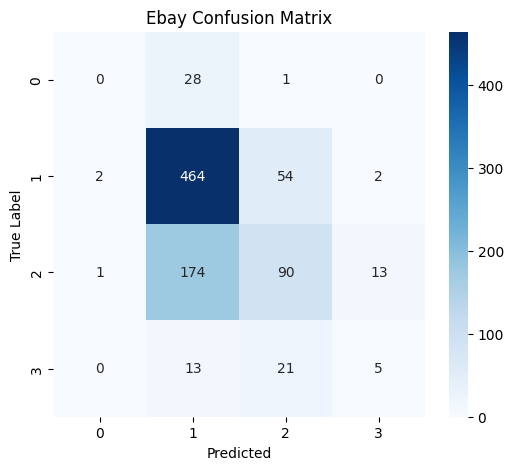

In [ ]:
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3])
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.title('Ebay Confusion Matrix')
plt.show()

In [ ]:
# 1. 重新訓練
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

# 2. 這次先存在本地，不要放 Google Drive
xgb.save_model("xgb_model.json")
print("✅ Trained model expects:", xgb.n_features_in_, "features.")

✅ Trained model expects: 80 features.


In [ ]:
torch.save(model.state_dict(), "distilbert_classifier.pth")
model.bert.save_pretrained("bert_model")
tokenizer.save_pretrained("bert_tokenizer")

('bert_tokenizer/tokenizer_config.json',
 'bert_tokenizer/special_tokens_map.json',
 'bert_tokenizer/vocab.txt',
 'bert_tokenizer/added_tokens.json')

In [ ]:
!ls -lh distilbert_classifier.pth

-rw-r--r-- 1 root root 254M Mar 31 06:58 distilbert_classifier.pth


# Gradio

In [ ]:
# pip install gradio transformers xgboost torch

  Using cached gradio-5.23.1-py3-none-any.whl.metadata (16 kB)
  Using cached aiofiles-23.2.1-py3-none-any.whl.metadata (9.7 kB)
  Using cached fastapi-0.115.12-py3-none-any.whl.metadata (27 kB)
  Using cached ffmpy-0.5.0-py3-none-any.whl.metadata (3.0 kB)
  Using cached gradio_client-1.8.0-py3-none-any.whl.metadata (7.1 kB)
  Using cached groovy-0.1.2-py3-none-any.whl.metadata (6.1 kB)
  Using cached pydub-0.25.1-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached python_multipart-0.0.20-py3-none-any.whl.metadata (1.8 kB)
  Using cached ruff-0.11.2-py3-none-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (25 kB)
  Using cached safehttpx-0.1.6-py3-none-any.whl.metadata (4.2 kB)
  Using cached semantic_version-2.10.0-py2.py3-none-any.whl.metadata (9.7 kB)
  Using cached starlette-0.46.1-py3-none-any.whl.metadata (6.2 kB)
  Using cached tomlkit-0.13.2-py3-none-any.whl.metadata (2.7 kB)
  Using cached uvicorn-0.34.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached nvidia_cuda_n

In [ ]:
import gradio as gr
import xgboost as xgb
import torch
from transformers import DistilBertTokenizer, DistilBertModel
import numpy as np
import torch.nn as nn

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# --------- 載入 tokenizer ----------
tokenizer = DistilBertTokenizer.from_pretrained("/content/drive/MyDrive/Colab Notebooks/Jill/bert_tokenizer")

# --------- 定義模型架構 ----------
class DistilBERTClassifier(nn.Module):
    def __init__(self, hidden_dim=48, num_classes=4):
        super(DistilBERTClassifier, self).__init__()
        self.bert = DistilBertModel.from_pretrained('/content/drive/MyDrive/Colab Notebooks/Jill/bert_model')
        self.bert_out = nn.Linear(768, hidden_dim)
        self.numeric_layer = nn.Linear(3, 32)
        self.batch_norm = nn.BatchNorm1d(32)
        self.dropout = nn.Dropout(0.4)
        self.classifier = nn.Linear(hidden_dim + 32, num_classes)
        self.relu = nn.ReLU()

    def forward_features(self, input_ids, attention_mask, numeric_features):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)[0][:, 0, :]
        bert_output = self.relu(self.bert_out(bert_output))
        numeric_output = self.relu(self.batch_norm(self.numeric_layer(numeric_features)))
        combined = torch.cat((bert_output, numeric_output), dim=1)
        return combined

# --------- 載入模型 ----------
model = DistilBERTClassifier()
model.load_state_dict(torch.load("distilbert_classifier.pth", map_location="cpu"))
model.eval()

# --------- 載入 XGBoost 模型 ----------
xgb_model = xgb.XGBClassifier()
xgb_model.load_model("/content/drive/MyDrive/Colab Notebooks/Jill/xgb_model.json")

# --------- 預處理 ----------
def preprocess_text_and_numeric(text, price, score, review_number):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=128)
    numeric_vec = torch.tensor([[float(price), float(score), float(review_number)]], dtype=torch.float)
    with torch.no_grad():
        features = model.forward_features(inputs['input_ids'], inputs['attention_mask'], numeric_vec)
    return features.numpy()

# --------- 預測函數 ----------
def predict(comment, product_name, price, score, review_number):
    try:
        text_input = str(comment) + " " + str(product_name)
        combined = preprocess_text_and_numeric(text_input, price, score, review_number)
        pred = xgb_model.predict(combined.astype(np.float32))
        return f"Result: Tier {int(pred[0])}"
    except Exception as e:
        print("❌ Error during prediction:", e)
        return "Error"

# Gradio Interface
iface = gr.Interface(
    fn=predict,
    inputs=[
        gr.Textbox(label="Comment"),
        gr.Textbox(label="Title"),
        gr.Number(label="Price"),
        gr.Number(label="Rating"),
        gr.Number(label="Review Number")
    ],
    outputs=gr.Textbox(label="Prediction Result"),
    title="DistilBERT + XGBoost Sales Tier Predictor",
    description="Input product details to predict its sales tier（Tier 0-3）"
)

iface.launch(debug=True)


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://373d273c2999475b19.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://373d273c2999475b19.gradio.live
